In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def getframe(sec_id):
    dfs = []
    date_from = "2020-01-01"
    date_to = "2024-10-31"
    url = f"https://iss.moex.com/iss/history/engines/stock/markets/shares/boards/tqbr/securities/{sec_id}/candles.html?from={date_from}&till={date_to}"

    retrieved = 0
    while True:
        df, cursor = pd.read_html(url + f"&start={retrieved}")
        dfs.append(df)
        retrieved += cursor.at[0, "PAGESIZE (int64)"]
        total = cursor.at[0, "TOTAL (int64)"]
        if retrieved >= total:
            break

    df = pd.concat(dfs, axis=0, ignore_index=True)
    return df
    

In [3]:
dfsber = getframe('sber')
dfvtb = getframe('vtbr')
dft = getframe('tcsg')

In [4]:
qsber = pd.to_datetime(dfsber['TRADEDATE (date:10)'])
qvtb = pd.to_datetime(dfvtb['TRADEDATE (date:10)'])
qt = pd.to_datetime(dft['TRADEDATE (date:10)'])

In [5]:
dfvtb_old = dfvtb[dfvtb['TRADEDATE (date:10)'] <= '2024-07-08']
dfvtb_new = dfvtb[dfvtb['TRADEDATE (date:10)'] >= '2024-07-15']

In [6]:
spfr = [dfsber, dfvtb_old, dfvtb_new, dft]
spbn = ['Сбер', 'ВТБ (до сплита)', 'ВТБ (после сплита)', 'Т-Банк']

В таблице, спарсенной с сайта Мосбиржи, содержится информация о торгах акций различных банков на каждый день с 1 января 2020 года по 31 октября 2024 года, за исключением выходных и праздничных дней.

Что содержится в каждой из колонок таблицы?

0 колонка - индекс

1 колонка (BOARDID) - идентификатор рынка. У нас это TQBR - основноый рынок акций на Мосбирже.

2 колонка (TRADEDATE) - дата торгов.

3 колонка (SHORTNAME) - имя компании 

4 колонка (SECID) - тикер банка

5 колонка (NUMTRADES) - количество сделок за день

6 колонка (VALUE) - денежный объем торгов (цена*количество; суммарная стоимость всех сделок с ценной бумагой за день)

7 колонка (OPEN) - цена открытия

8 колонка (LOW) - минимальная цена

9 колонка (HIGH) - максимальная цена

10 колонка (LEGALCLOSEPRICE) - официальная цена закрытия

11 колонка (WAPRICE) - средневзвешенная цена

12 колонка (CLOSE) - фактическая цена закрытия

13 колонка (VOLUME) - количество акций, проданных или купленных за день

14 колонка (MARKETPRICE2) - рыночная цена 2

15 колонка (MARKETPRICE3) - рыночная цена 3

16 колонка (ADMITTEDQUOTE) - признаваемая котировка

17 колонка (MP2VALTRD) - объём сделок для расчёта рыночной цены

18 колонка (MARKETPRICE3TRADESVALUE) - значение рыночной цены 3 по итогам торгового дня

19 колонка (ADMITTEDVALUE) -  объём сделок для расчёта признаваемой котировки

20 колонка (WAVAL) - средневзвешенная стоимость актива, рассчитанная на основе объема торгов

21 колонка (TRADINGSESSION) - идентификатор торговой сессии

22 колонка (CURRENCYID) - индкентификатор валюты - рубль.

23 колонка (TRENDCLSPR) - индикатор тренда, разница между текущей ценой закрытия и предыдущей ценой закрытия, выраженная в процентах

In [7]:
for df in spfr:
    nulls = df.isnull().sum(axis = 0)
    print(nulls)

BOARDID (string:12)                    0
TRADEDATE (date:10)                    0
SHORTNAME (string:189)                 0
SECID (string:36)                      0
NUMTRADES (double)                     0
VALUE (double)                         0
OPEN (double)                         18
LOW (double)                          18
HIGH (double)                         18
LEGALCLOSEPRICE (double)               0
WAPRICE (double)                      18
CLOSE (double)                        18
VOLUME (double)                        0
MARKETPRICE2 (double)                  7
MARKETPRICE3 (double)                  0
ADMITTEDQUOTE (double)               458
MP2VALTRD (double)                     0
MARKETPRICE3TRADESVALUE (double)       0
ADMITTEDVALUE (double)               458
WAVAL (double)                       115
TRADINGSESSION (int32)                 0
CURRENCYID (string:9)                  0
TRENDCLSPR (double)                   18
TRADE_SESSION_DATE (date:10)        1224
dtype: int64
BOA

Как мы видим, кое-где в колонках есть пропуски. Для каждого банка количество пропусков в столбцах OPEN (double), LOW (double), HIGH (double), CLOSE (double), TRENDCLSPR (double) одинаково. Связано это с тем, что пропуски в этих столбцах выпадали на те рабочие даты, в которых почему-то не проводились торги. Об этом чуть позже. Пропуски в колонке ADMITTEDQUOTE, ADMITTEDVALUE (double) связаны с отсутствием котировок. Такое могло возникнуть из-за отсутствия или приостановки торгов, тех. проблем или торговлей вне основной торговой сессии. Пропуски в WAVAL могут быть связаны с отсутствием сделок, низкой ликвидностью, тех. сбоями, изменениями правил расчёта или длительными перерывами в торговле. В связи с вышеобозначенными причинами наша команда решила, что заполнять пропуски какими-то значениями будет нерелевантно, так как это не будет отображать реальное положение дел на бирже.

In [8]:
for df in spfr:
    a = df['TRADEDATE (date:10)'][(df['OPEN (double)'].isnull() == True) | (df['LOW (double)'].isnull() == True) | (df['HIGH (double)'].isnull() == True) | (df['CLOSE (double)'].isnull() == True) | (df['TRENDCLSPR (double)'].isnull() == True)]
    cond = df['TRADEDATE (date:10)'].isin(a)
    df['Были ли торги'] = np.where(cond, 'нет', 'да')
    df['Разброс цен'] = df['HIGH (double)'] - df['LOW (double)']
    df['Категория по средневзвешенной цене'] = pd.qcut(df['WAPRICE (double)'], q = 3, labels = ['low', 'medium', 'high'])
    df['Прирост количества торгуемых акций'] = df['VOLUME (double)'].diff() / df['VOLUME (double)'].shift()
    df['Доходность по средневзвешенной цене'] = df['WAPRICE (double)'].diff() / df['WAPRICE (double)'].shift()
    df['Прирост количества сделок'] = df['NUMTRADES (double)'].diff() / df['NUMTRADES (double)'].shift()
    print(a)


509    2022-01-07
542    2022-02-23
545    2022-02-28
546    2022-03-01
547    2022-03-02
548    2022-03-03
549    2022-03-04
550    2022-03-09
551    2022-03-10
552    2022-03-11
553    2022-03-14
554    2022-03-15
555    2022-03-16
556    2022-03-17
557    2022-03-18
558    2022-03-21
559    2022-03-22
560    2022-03-23
Name: TRADEDATE (date:10), dtype: object
509    2022-01-07
542    2022-02-23
545    2022-02-28
546    2022-03-01
547    2022-03-02
548    2022-03-03
549    2022-03-04
550    2022-03-09
551    2022-03-10
552    2022-03-11
553    2022-03-14
554    2022-03-15
555    2022-03-16
556    2022-03-17
557    2022-03-18
558    2022-03-21
559    2022-03-22
560    2022-03-23
Name: TRADEDATE (date:10), dtype: object
Series([], Name: TRADEDATE (date:10), dtype: object)
509     2022-01-07
542     2022-02-23
545     2022-02-28
546     2022-03-01
547     2022-03-02
548     2022-03-03
549     2022-03-04
550     2022-03-09
551     2022-03-10
552     2022-03-11
553     2022-03-14
554     

C:\Users\jeoki\AppData\Local\Temp\ipykernel_25512\1138942893.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Были ли торги'] = np.where(cond, 'нет', 'да')
C:\Users\jeoki\AppData\Local\Temp\ipykernel_25512\1138942893.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Разброс цен'] = df['HIGH (double)'] - df['LOW (double)']
C:\Users\jeoki\AppData\Local\Temp\ipykernel_25512\1138942893.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

В основном, отстутствие торгов было в период марта 2022 года. С 28 февраля 2022 года Московская биржа приостановила торговлю акциями ряда компаний, включая Сбербанк, ВТБ и Тинькофф, чтобы предотвратить резкое падение цен на акции и обеспечить стабильность финансовой системы. Это связано с политическим шоком.

In [9]:
w = []
t = []
for df in spfr:
    jk = df.drop(columns = ['BOARDID (string:12)', 'TRADEDATE (date:10)', 'SHORTNAME (string:189)', 'SECID (string:36)', 'WAVAL (double)', 'TRADINGSESSION (int32)', 'CURRENCYID (string:9)', 'TRADE_SESSION_DATE (date:10)', 'Были ли торги', 'Категория по средневзвешенной цене'])
    nk = jk.columns
    stat = dict()
    stat['Показатель'] = ['среднее', 'медиана', '25% квантиль', '50% квантиль', '75% квантиль', 'минимум', 'максимум', 'ст. откл.']
    for el in nk:
        stat[el] = [df[el].mean(), df[el].median(), df[el].quantile(q = 0.25), df[el].quantile(q = 0.5), df[el].quantile(q = 0.75), df[el].min(), df[el].max(), df[el].std()]
    framestat = pd.DataFrame(stat)
    w.append(framestat)
    t.append(jk.corr())
print(w[0])
print(w[1])
print(w[2])

print(t[0])
print(t[1])
print(t[2])

     Показатель  NUMTRADES (double)  VALUE (double)  OPEN (double)  \
0       среднее        1.126949e+05    1.420012e+10     240.891045   
1       медиана        9.450300e+04    1.093446e+10     257.830000   
2  25% квантиль        6.814725e+04    7.287915e+09     198.867500   
3  50% квантиль        9.450300e+04    1.093446e+10     257.830000   
4  75% квантиль        1.276870e+05    1.673369e+10     289.160000   
5       минимум        0.000000e+00    0.000000e+00      96.550000   
6      максимум        1.559658e+06    2.385837e+11     385.880000   
7     ст. откл.        9.583588e+04    1.419806e+10      65.806013   

   LOW (double)  HIGH (double)  LEGALCLOSEPRICE (double)  WAPRICE (double)  \
0     237.74757     243.589461                239.324338        240.693375   
1     254.72000     260.475000                256.820000        257.305000   
2     195.07500     203.887500                195.645000        199.517500   
3     254.72000     260.475000                256.820000 

C:\Users\jeoki\PycharmProjects\data_analysis_project_2025\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\jeoki\PycharmProjects\data_analysis_project_2025\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\jeoki\PycharmProjects\data_analysis_project_2025\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\jeoki\PycharmProjects\data_analysis_project_2025\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\jeoki\PycharmProjects\data_analysis_project_2025\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return

Как видно:
Для Сбера среднее количество сделок в день было в районе 113 тыс. Средняя цена - 241 руб. Макс. число сделок - 1 559 658 в день. Макс. цена - 388 руб. Ст. отклонение по цене закрытия - 65 руб. Средняя доходность в районе нуля.
Для ВТБ  среднее количество сделок в день было в районе 58 тыс. Средняя цена - 6 руб. Макс. число сделок - 435 775 в день. Макс. цена - 102 руб. Ст. отклонение по цене закрытия - 23 руб. Средняя доходность в районе нуля. Надо сказать, что статистика по ВТБ в черновом варианте не очень репрезентативна, т. к. банк сделал обратный сплит.
Для Т-банка  среднее количество сделок в день было в районе 30 тыс. Средняя цена - 3244 руб. Макс. число сделок - 440 874 в день. Макс. цена - 8518 руб. Ст. отклонение по цене закрытия - 1620 руб. Средняя доходность в районе нуля. 

По таблице корреляции видно, что все показатели, так или иначе обозначающие цену акций (цена открытия, закрытия, макс. цена, мин. цена, средневзвеш. цена) очень сильно коррелируют между собой (коэф в районе 0,99). А вот доходность не коррелирует почти, разве что только с TRENDCLSPR (double) (коэф  в районе 0,7 - 0,8). Связано это со схожими механизмами расчета: доходность это разница средневзвешенных цен соседних дней, деленная на средневзвешенную цену предыдущего дня, а TRENDCLSPR (double) -  индикатор тренда, разница между текущей ценой закрытия и предыдущей ценой закрытия, выраженная в процентах


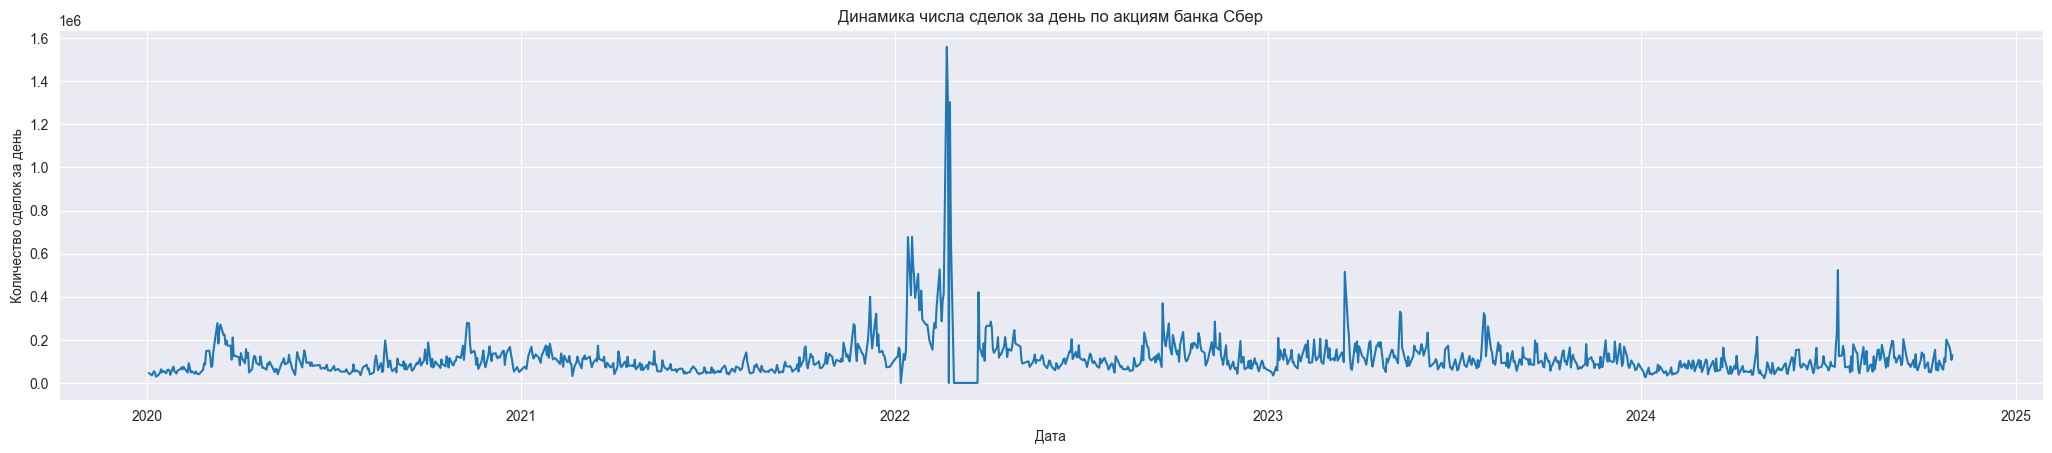

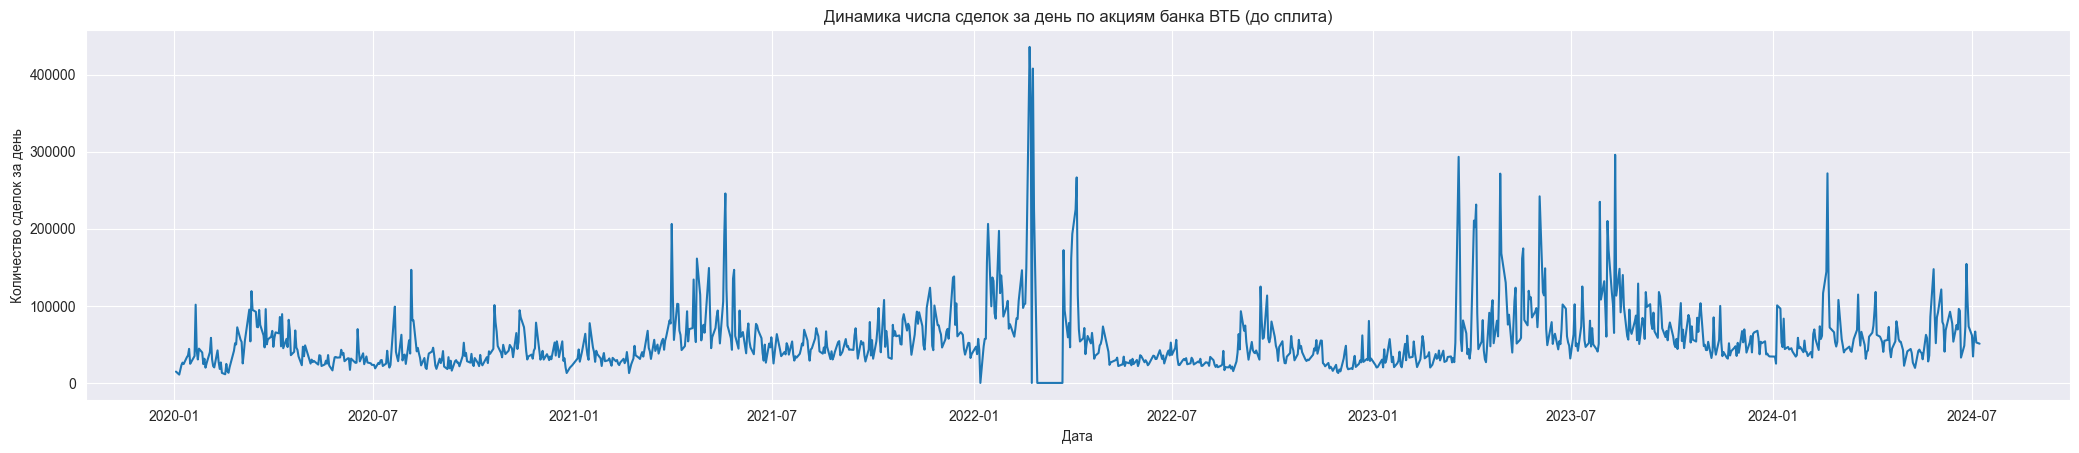

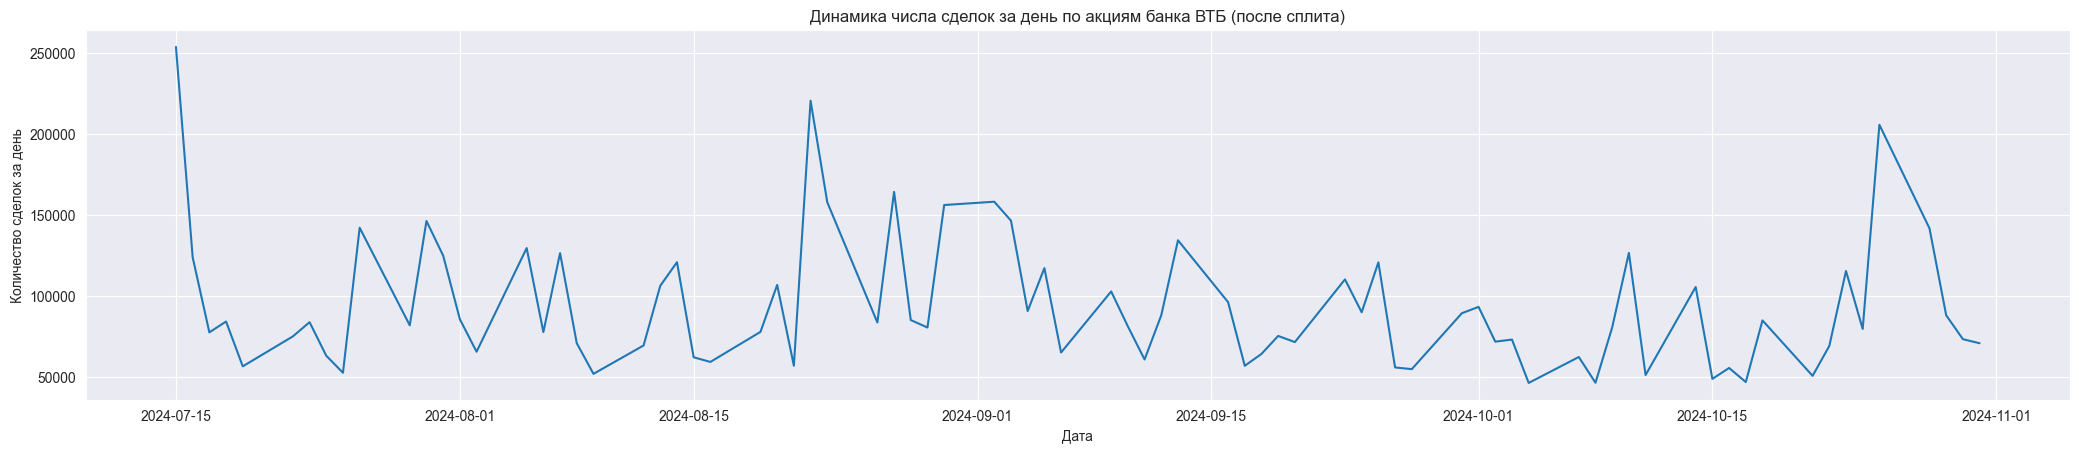

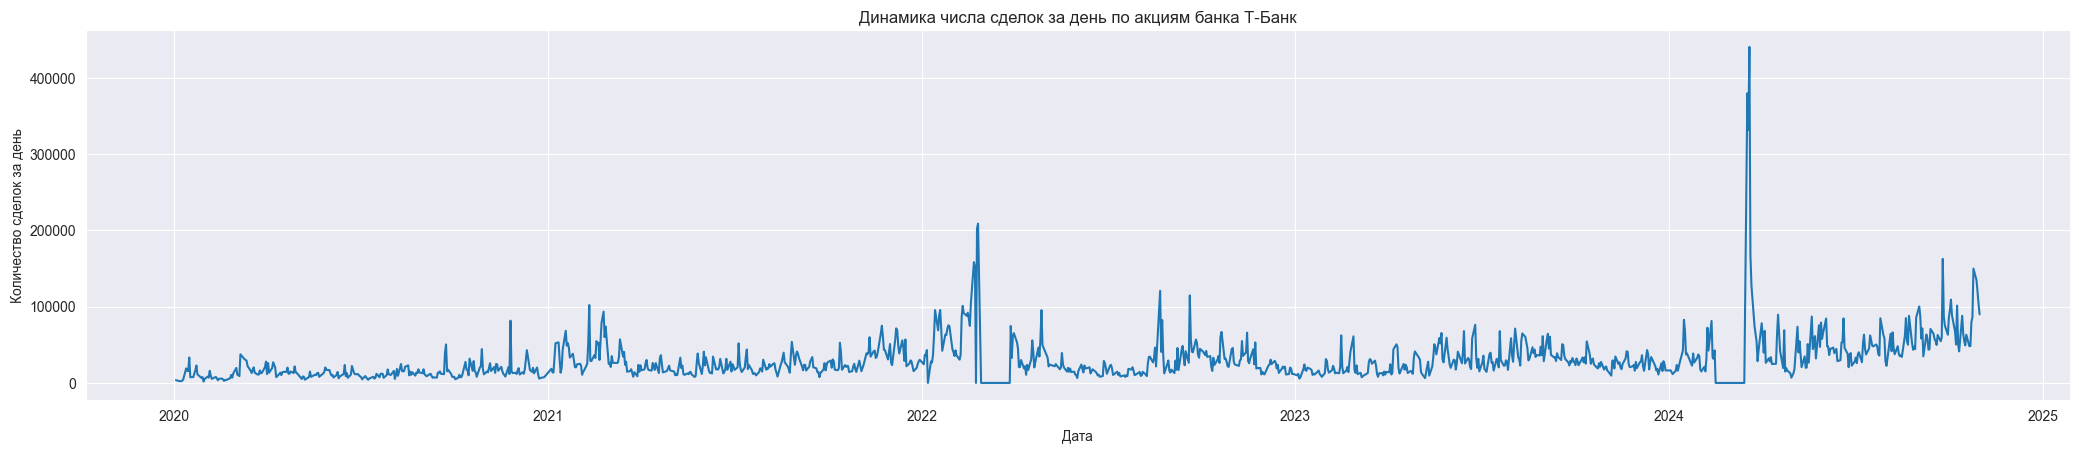

In [10]:
for df, name in zip(spfr, spbn):
    q = pd.to_datetime(df['TRADEDATE (date:10)'])
    plt.figure(figsize=(25.6, 4.8))
    plt.plot(q, df["NUMTRADES (double)"])
    plt.xlabel('Дата')
    plt.ylabel('Количество сделок за день')
    plt.title('Динамика числа сделок за день по акциям банка ' + name)
    plt.show()

Как видим, у всех банков в какой-то момент резко подскочило число сделок, а затем упало до нуля (2022 год). Это связано с кризисом февраля 2022 года (резкиим повышением активности и приостановкой торгов). Число сделок ВТБ было очень волатильным в 2023-2024 гг., а в какой-то момент 2024 года у Т-Банка резко поднялось число сделок, правда потом упало.

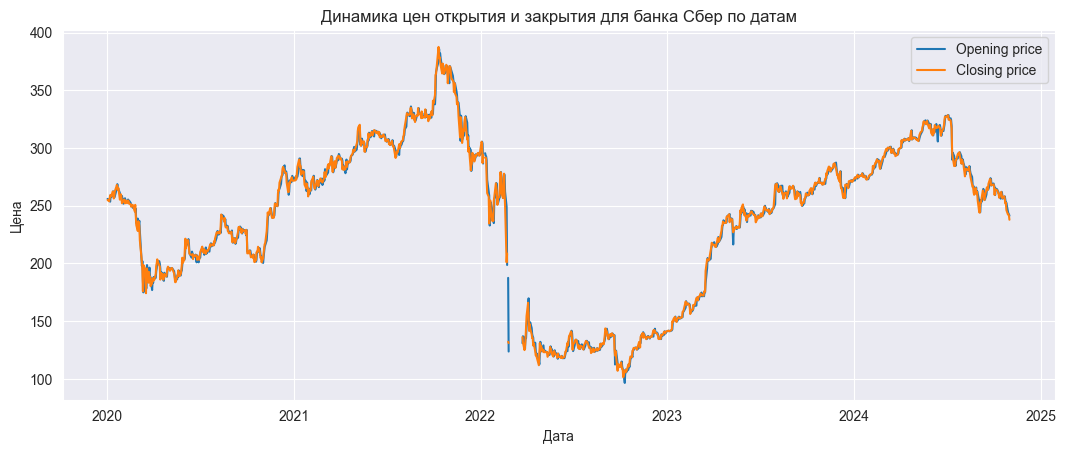

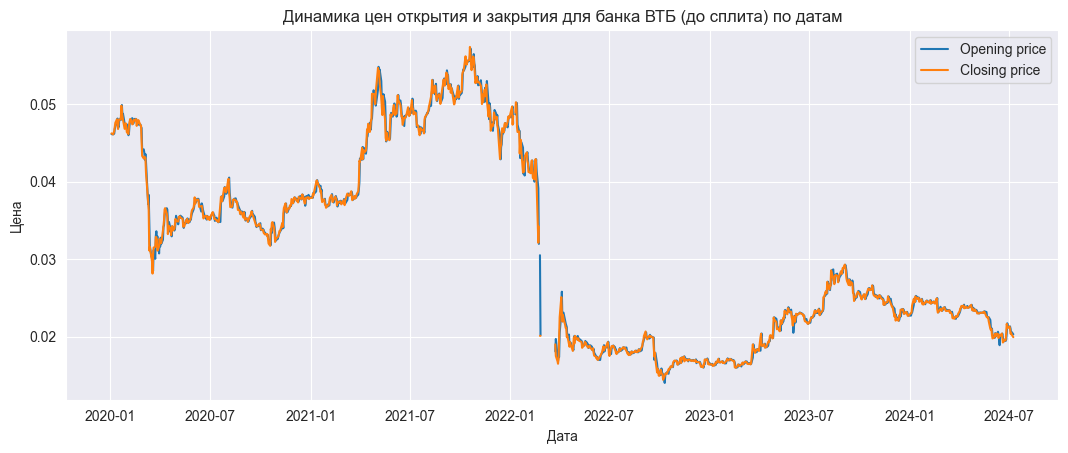

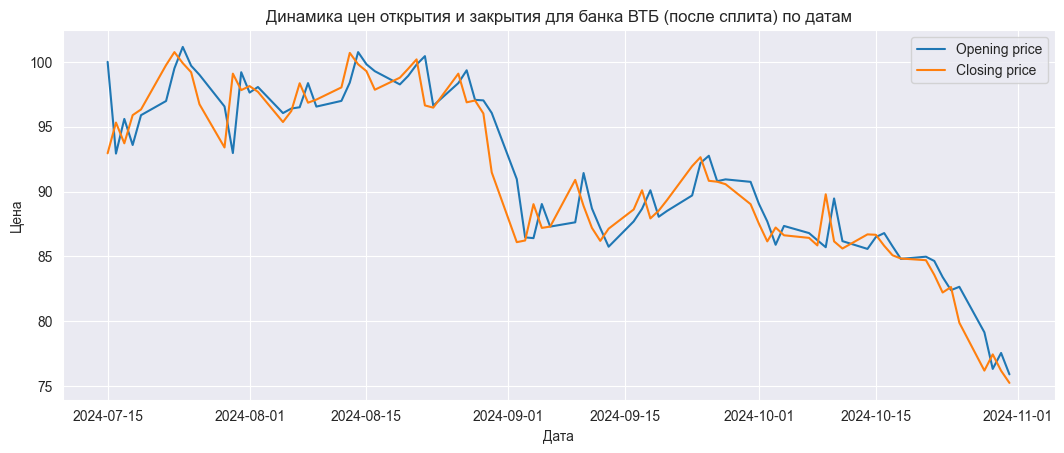

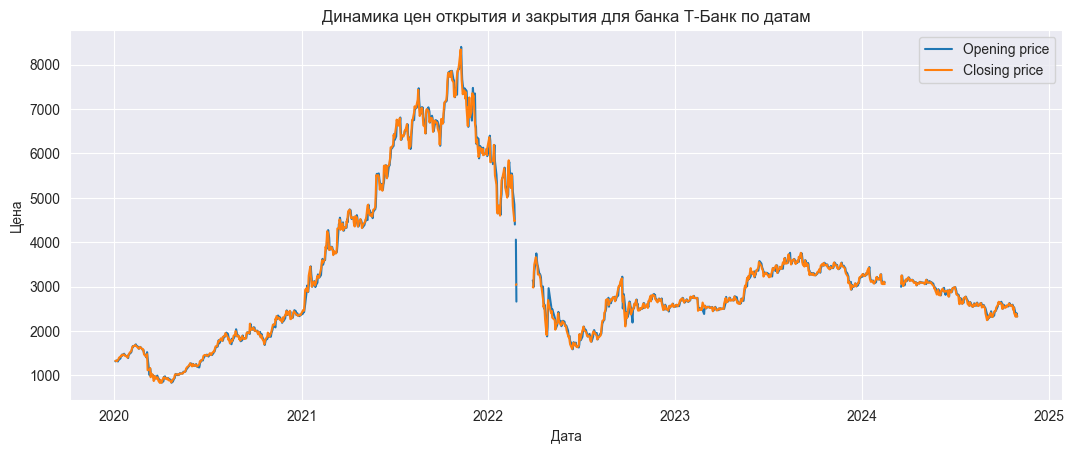

In [11]:
for df, name in zip(spfr, spbn):
    q = pd.to_datetime(df['TRADEDATE (date:10)'])
    plt.figure(figsize=(12.8, 4.8))
    plt.plot(q, df["OPEN (double)"], label="Opening price")
    plt.plot(q, df["CLOSE (double)"], label="Closing price")
    plt.xlabel("Дата")
    plt.ylabel("Цена")
    plt.legend()
    plt.title('Динамика цен открытия и закрытия для банка ' + name + ' по датам')
    plt.show()

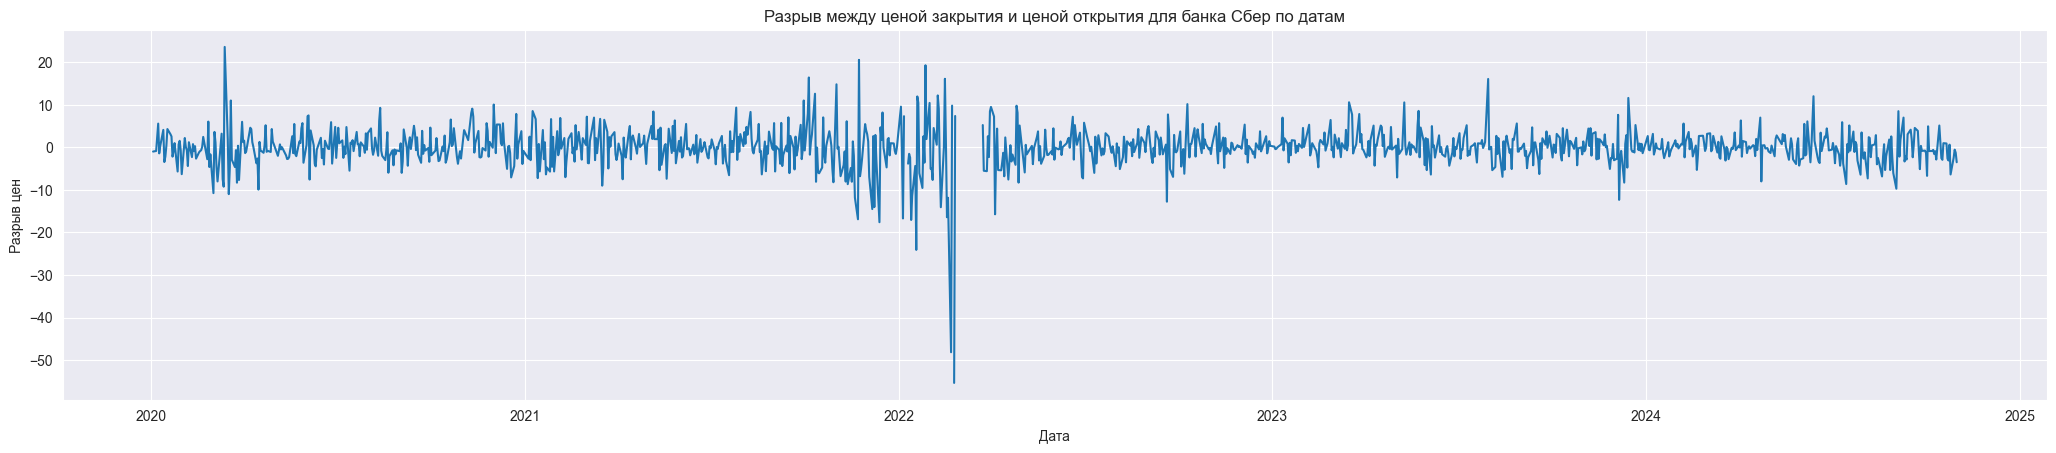

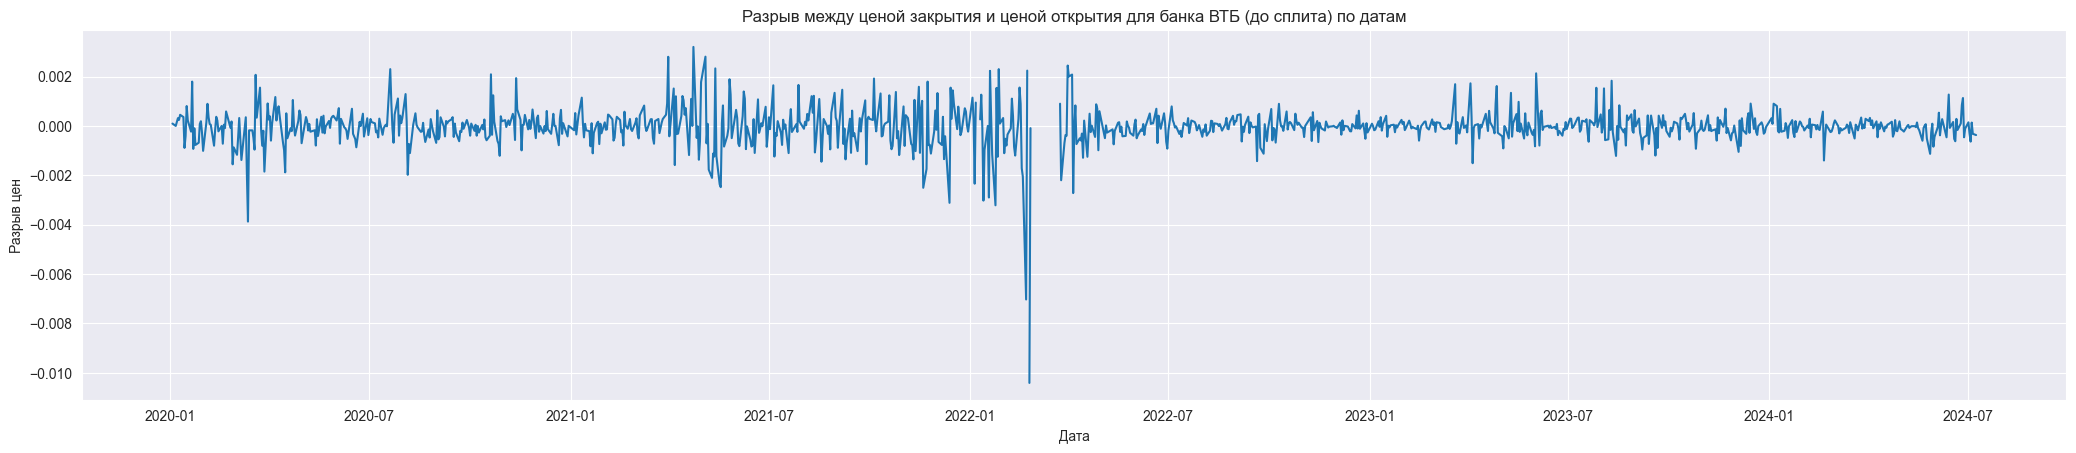

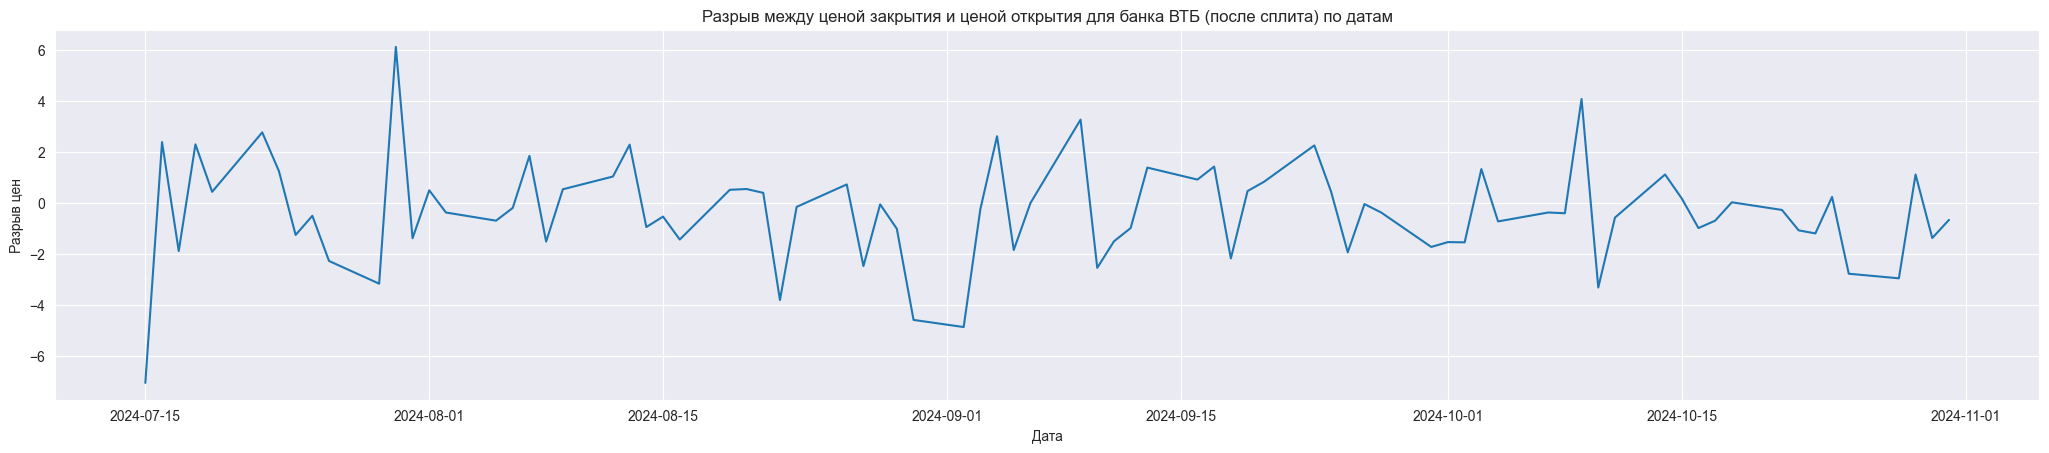

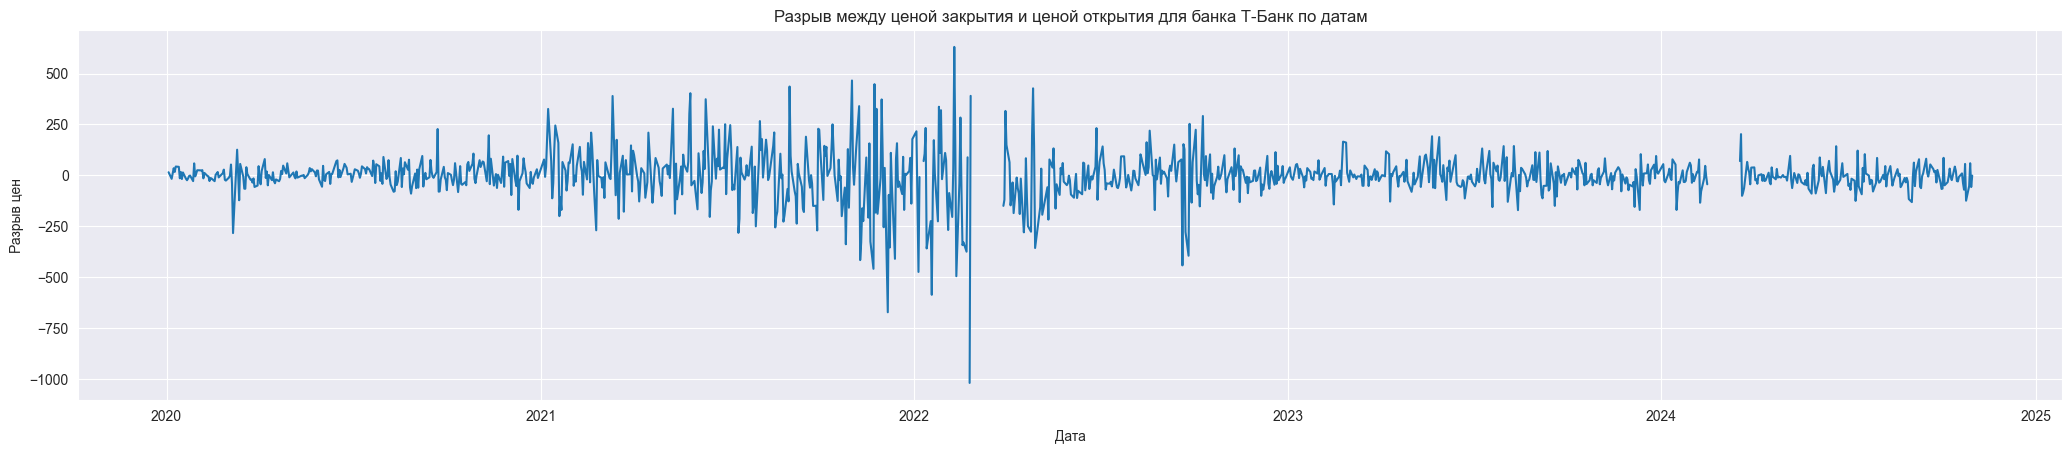

In [12]:
for df, name in zip(spfr, spbn):
    q = pd.to_datetime(df['TRADEDATE (date:10)'])
    close_open_delta = df["CLOSE (double)"] - df["OPEN (double)"]
    plt.figure(figsize=(25.6, 4.8))
    plt.plot(q, close_open_delta)
    plt.title('Разрыв между ценой закрытия и ценой открытия для банка ' + name + ' по датам')
    plt.xlabel('Дата')
    plt.ylabel('Разрыв цен')
    plt.show()

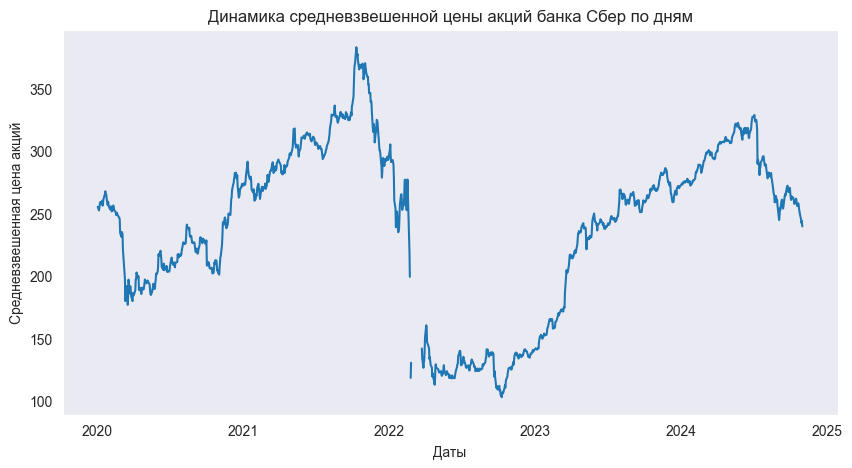

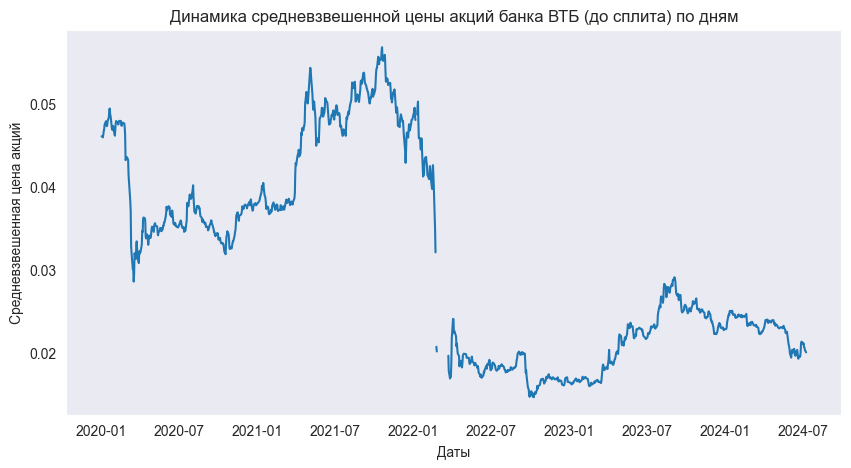

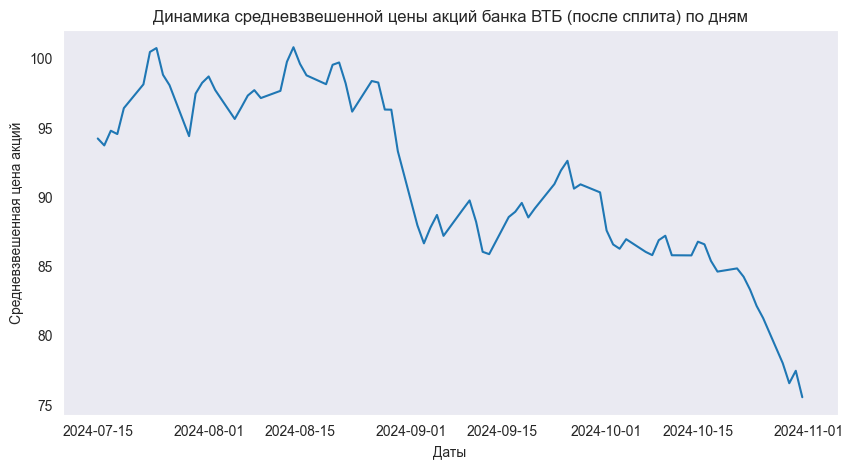

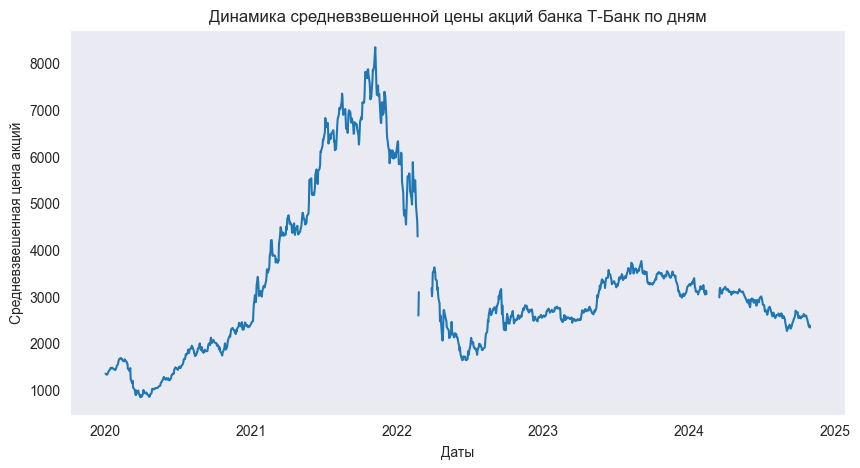

In [13]:
for df, name in zip(spfr, spbn):
    q = pd.to_datetime(df['TRADEDATE (date:10)'])
    plt.figure(figsize = (10, 5))
    plt.plot(q, df['WAPRICE (double)'])
    plt.grid()
    plt.title('Динамика средневзвешенной цены акций банка ' + name + ' по дням')
    plt.xlabel('Даты')
    plt.ylabel('Средневзвешенная цена акций')
    plt.show()

До кризиса определенного момента 2021 года (выясним конкретику позже) акции сбера и Т росли. Затем падали до февраля 2022 г. Затем были приостановлены торги.  Затем акции продолжили падать немного, потом пошли вверх, а потом опять начали падать, но медленно.
У ВТБ отдельная история. До сплита акции стоили очень мало, график не отражает динамику. Виден момент приостановки торгов в марте 2022 г. А после сплита акции взлетели до 100, но демонстрировали нисходящий тренд.

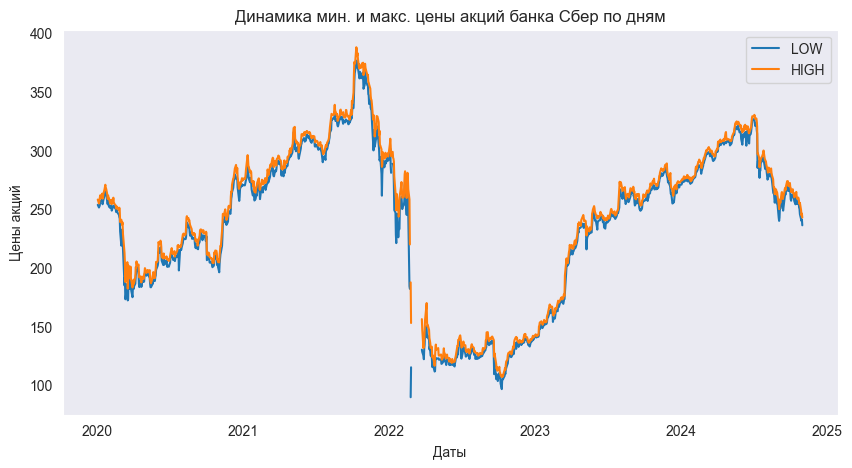

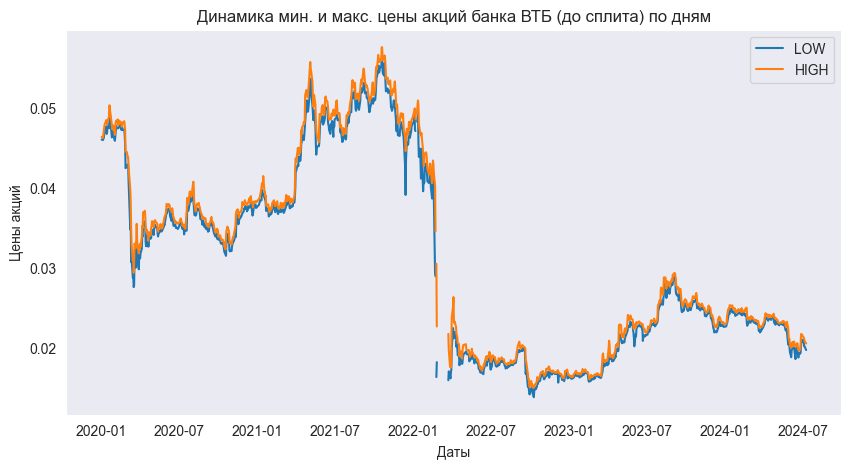

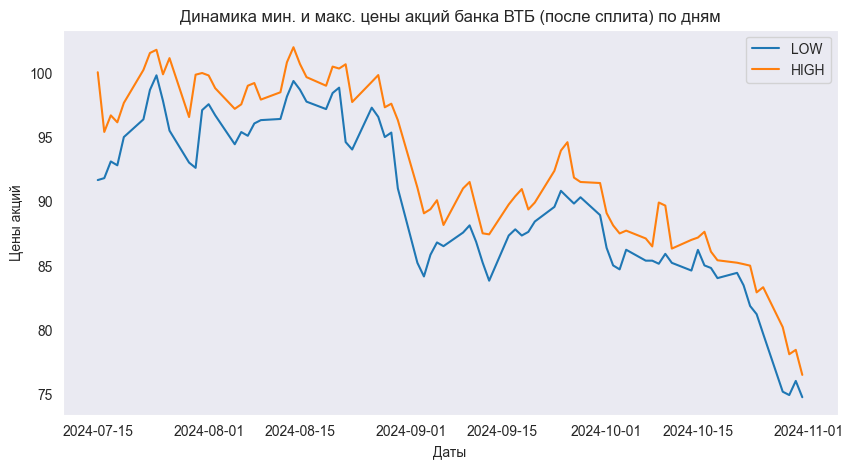

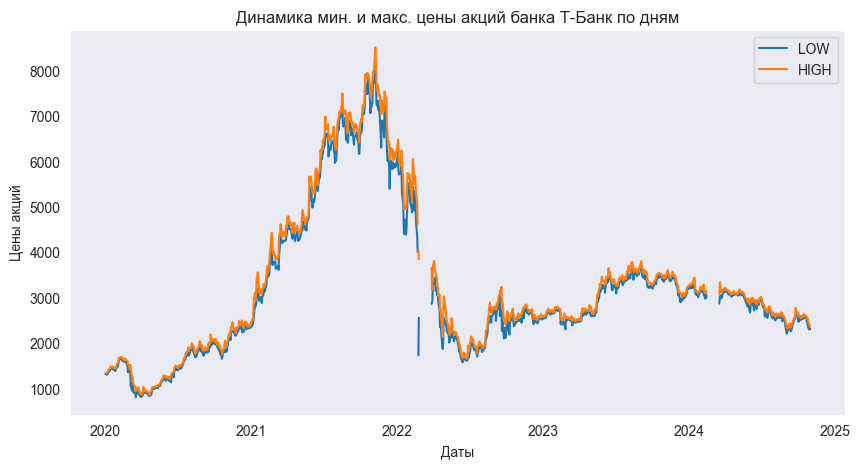

In [14]:
for df, name in zip(spfr, spbn):
    q = pd.to_datetime(df['TRADEDATE (date:10)'])
    plt.figure(figsize = (10, 5))
    plt.plot(q, df['LOW (double)'], label = 'LOW')
    plt.plot(q, df['HIGH (double)'], label = 'HIGH' )
    plt.grid()
    plt.legend()
    plt.title('Динамика мин. и макс. цены акций банка ' + name +' по дням')
    plt.xlabel('Даты')
    plt.ylabel('Цены акций')
    plt.show()

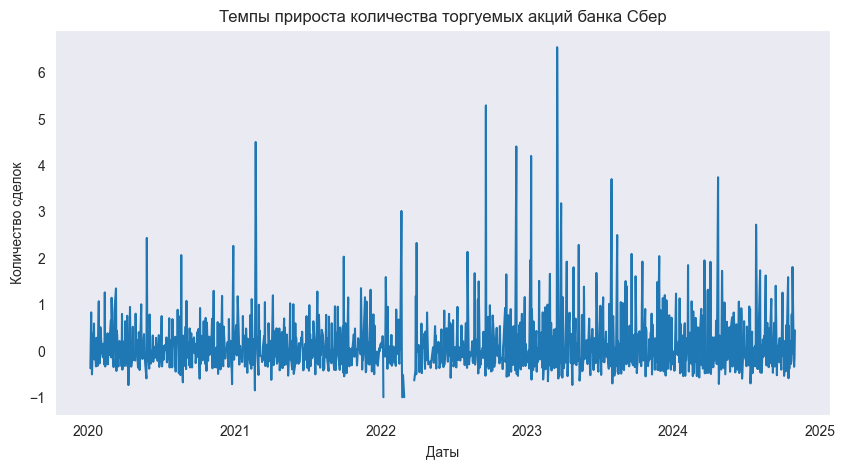

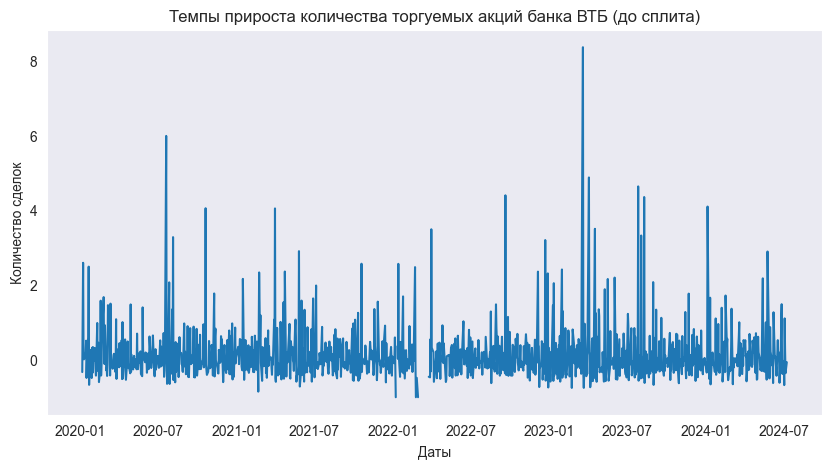

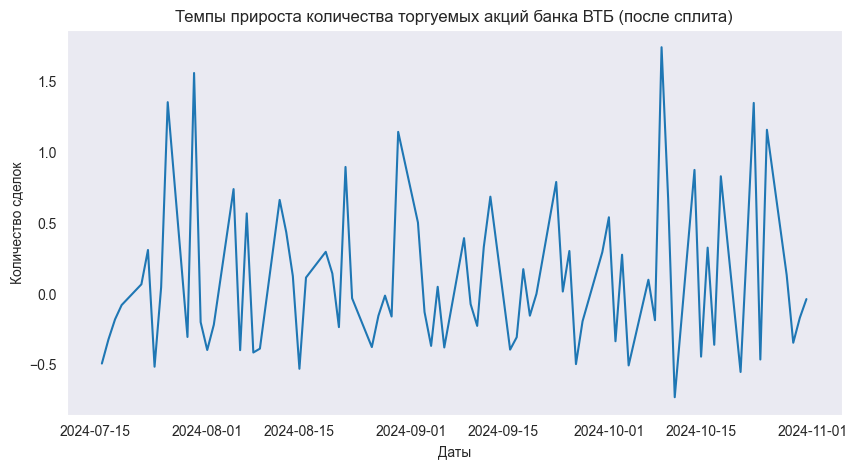

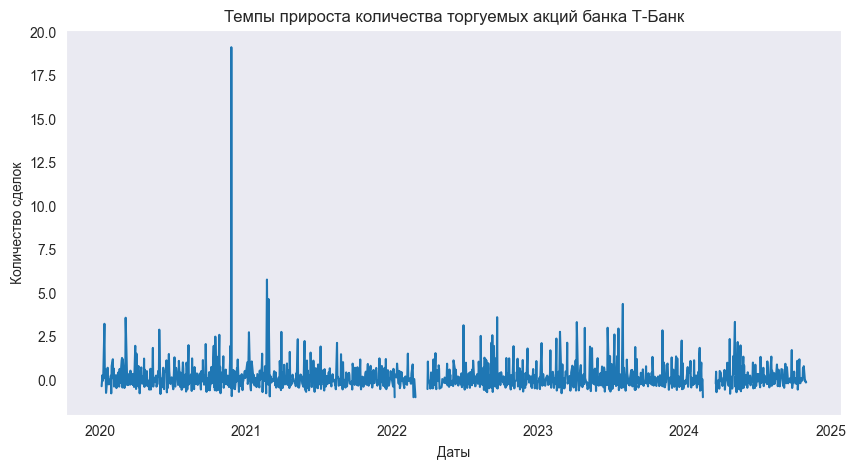

In [18]:
for df, name in zip(spfr, spbn):
    q = pd.to_datetime(df['TRADEDATE (date:10)'])
    plt.figure(figsize = (10, 5))
    plt.plot(q, df['Прирост количества торгуемых акций'])
    plt.grid()
    plt.title('Темпы прироста количества торгуемых акций банка ' + name)
    plt.xlabel('Даты')
    plt.ylabel('Количество сделок')
    plt.show()

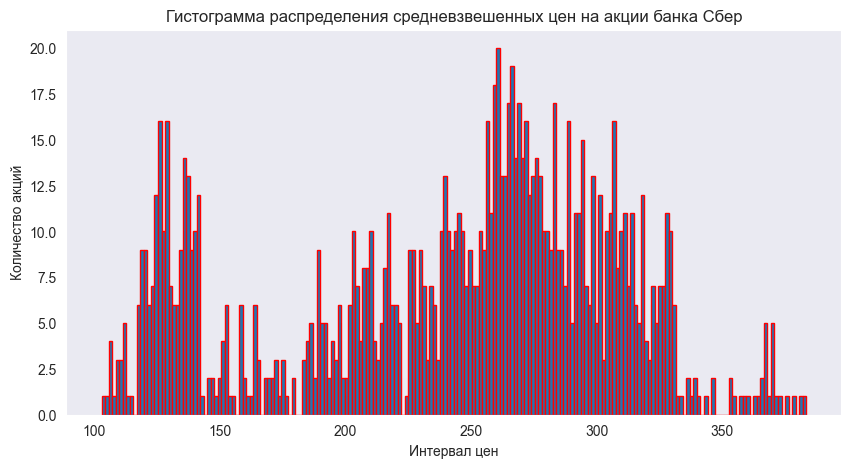

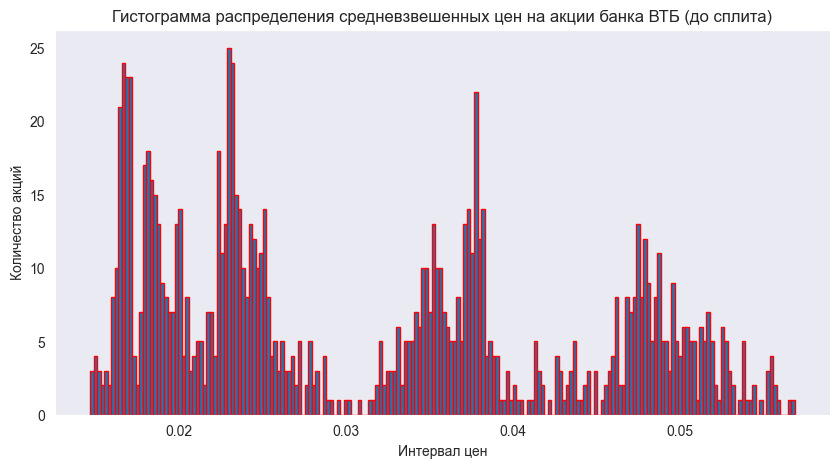

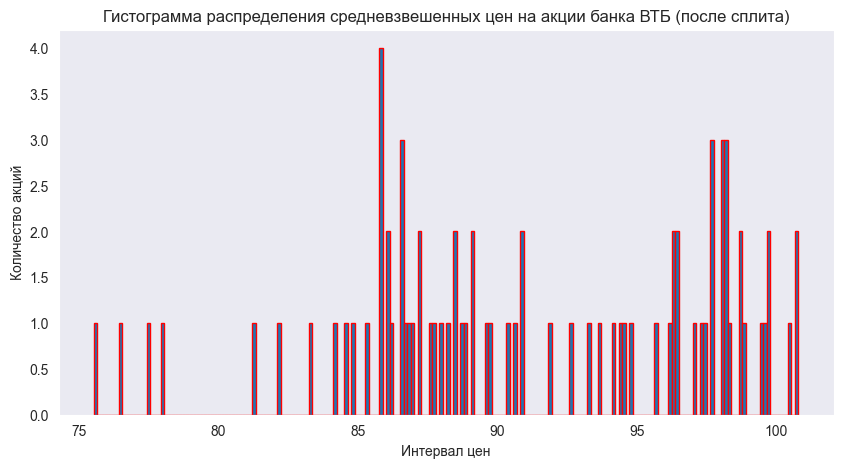

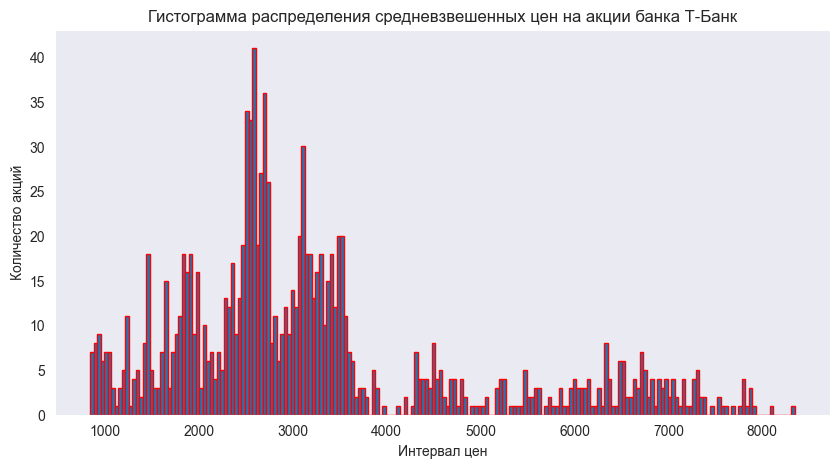

In [16]:
for df, name in zip(spfr, spbn):
    plt.figure(figsize = (10, 5))
    plt.hist(df['WAPRICE (double)'], bins = 200, edgecolor = 'red')
    plt.grid()
    plt.title('Гистограмма распределения средневзвешенных цен на акции банка ' + name)
    plt.xlabel('Интервал цен')
    plt.ylabel('Количество акций')
    plt.show()

По гистограмме цен видно,, что основная масса цен сбера сосредоточилась в промежутке от 200 до 350. Также большая доля есть от 100 до 150.
Для сновная масса в районе нуля, остальные цены имеют очень низкую частоту. Это к истории сдешевыми акциями и сплитом.
Для Т-банка есть большое скопление в промежутке от 1000 до 4000 руб., а цены выше имеют более низкую частоту.

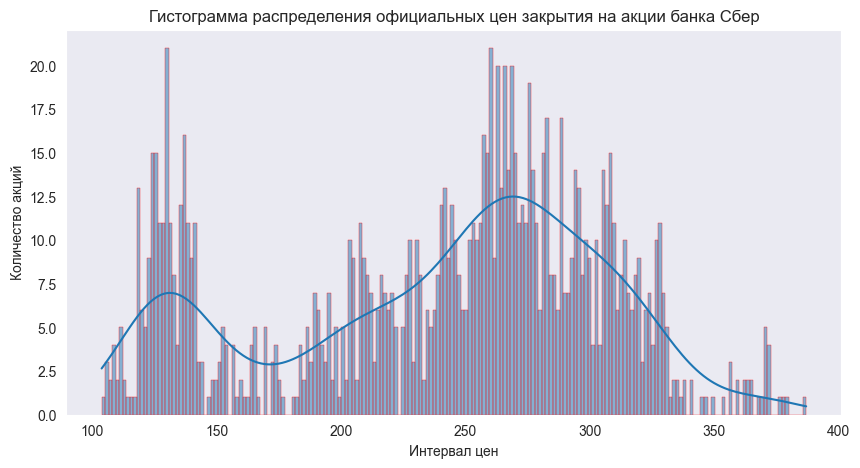

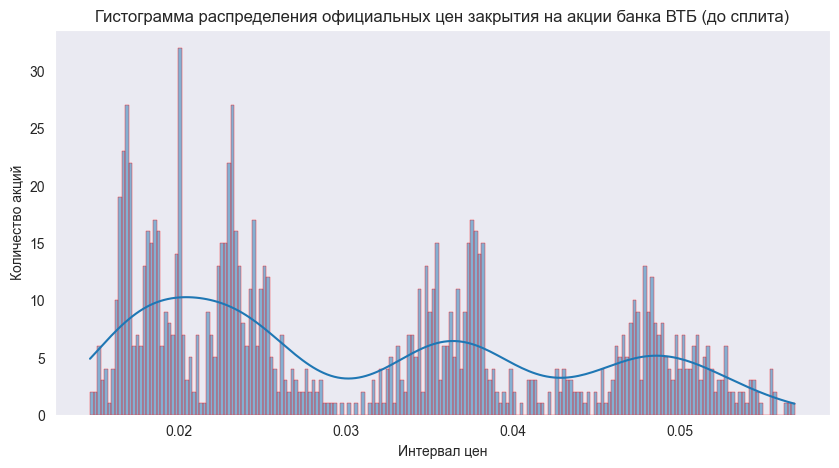

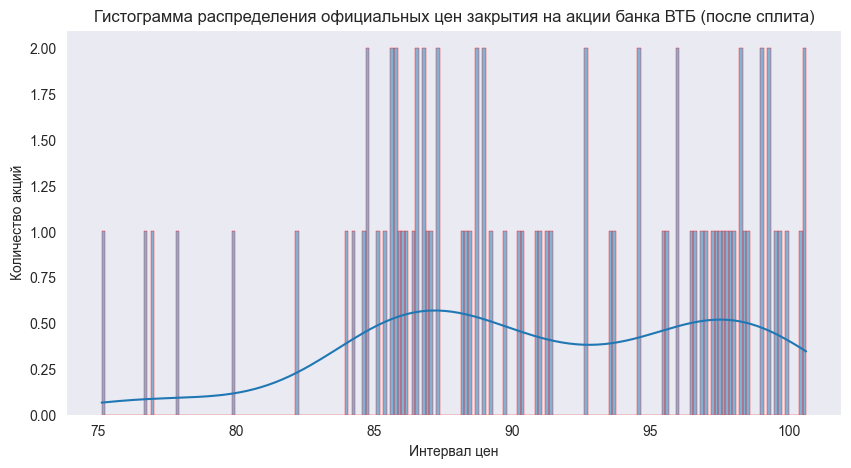

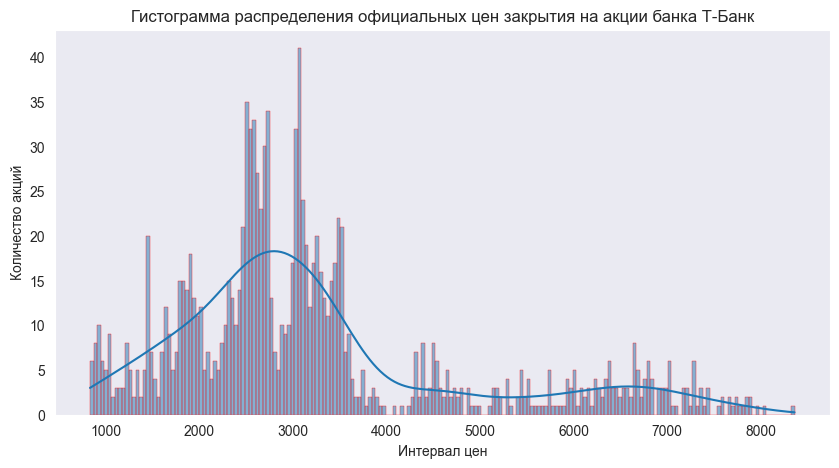

In [19]:
for df, name in zip(spfr, spbn):
    plt.figure(figsize = (10, 5))
    sns.histplot(df['LEGALCLOSEPRICE (double)'], bins = 200, edgecolor = 'red', kde = True)
    plt.grid()
    plt.title('Гистограмма распределения официальных цен закрытия на акции банка ' + name)
    plt.xlabel('Интервал цен')
    plt.ylabel('Количество акций')
    plt.show()

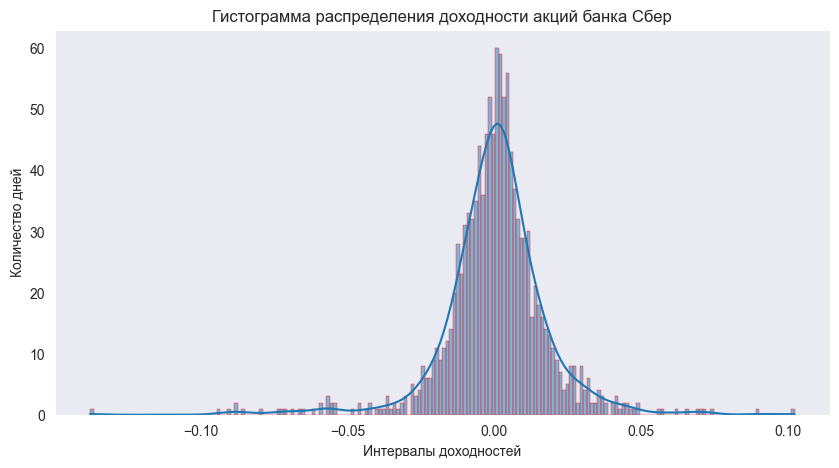

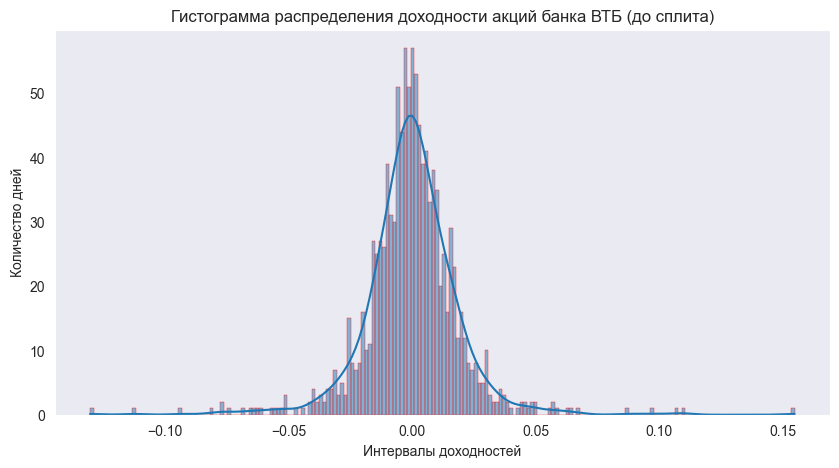

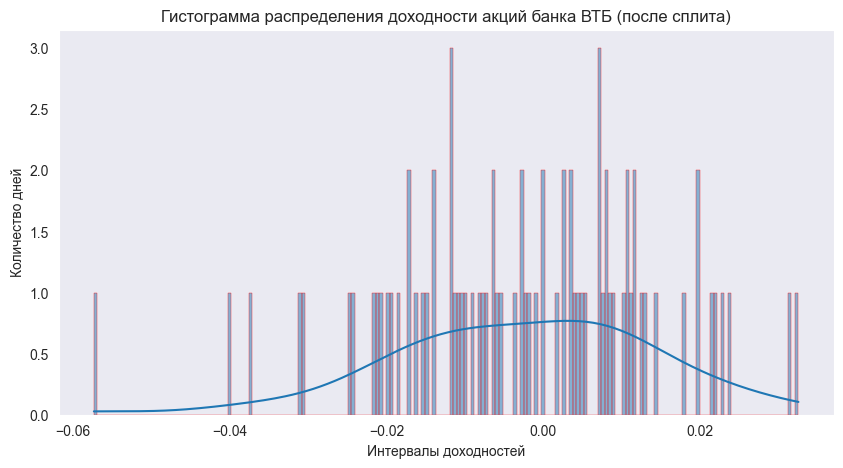

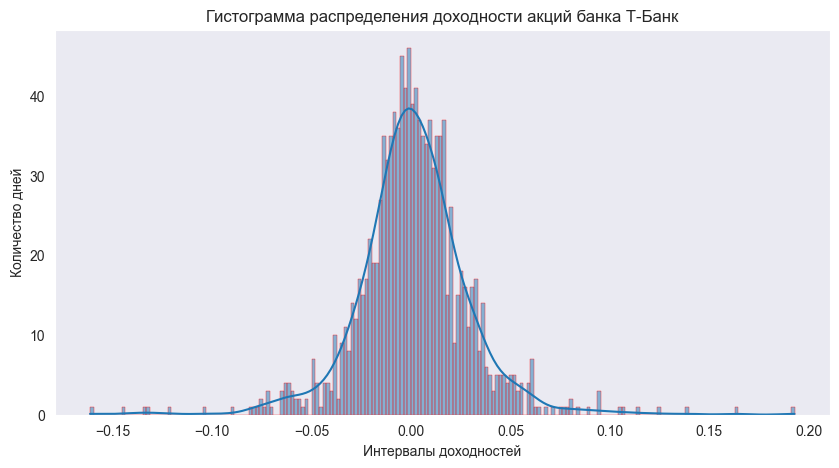

In [20]:
for df, name in zip(spfr, spbn):
    plt.figure(figsize = (10, 5))
    sns.histplot(df['Доходность по средневзвешенной цене'], bins = 200, edgecolor = 'red', kde = True)
    plt.grid()
    plt.title('Гистограмма распределения доходности акций банка ' + name)
    plt.xlabel('Интервалы доходностей')
    plt.ylabel('Количество дней')
    plt.show()

Гистограммы доходностей напоминают нормальное распределение с нулевым мат. ожиданием. Хвосты относительно равномерные. Отклоняясь по графикам от нулевой доходности в любую сторону, частота дней, в которых была такая доходность, убывает.

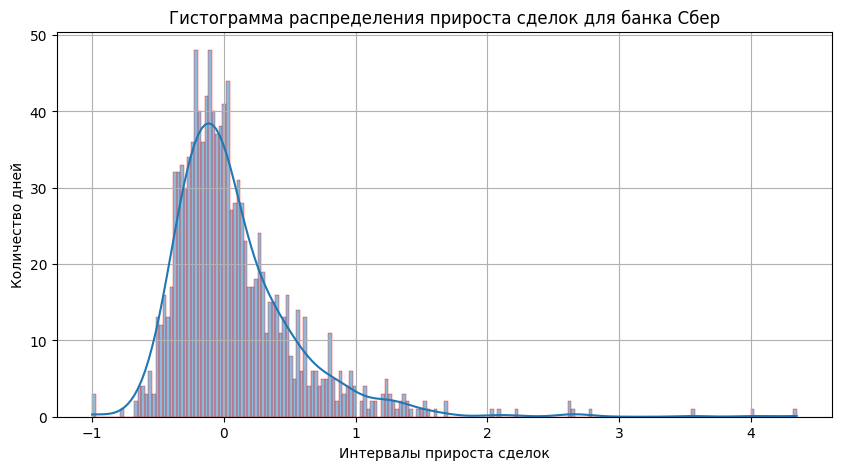

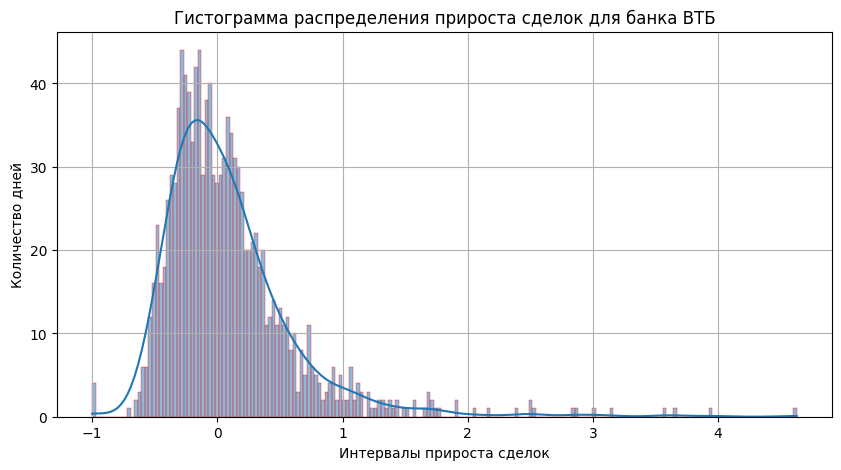

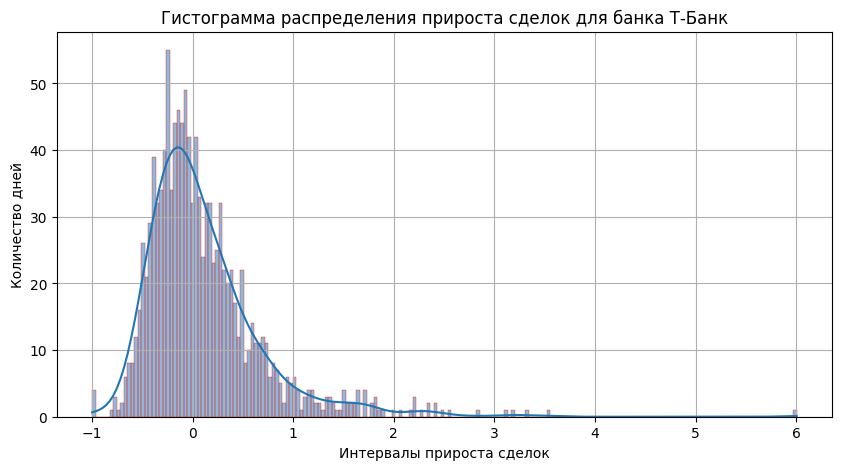

In [19]:
for df, name in zip(spfr, spbn):
    plt.figure(figsize = (10, 5))
    sns.histplot(df['Прирост количества сделок'], bins = 200, edgecolor = 'red', kde = True)
    plt.grid()
    plt.title('Гистограмма распределения прироста сделок для банка ' + name)
    plt.xlabel('Интервалы прироста сделок')
    plt.ylabel('Количество дней')
    plt.show()

# Гипотезы
### 1. Распределение доходностей близко к нормальному
### 2. Между показателями Сбера и Т-Банка (такими, как цены и доходности) наблюдается высокая корреляция.
### 3. Распределение прироста сделок близко к логнормальному.

# Merge таблиц

In [21]:
dfsber=dfsber.drop(["BOARDID (string:12)", "SHORTNAME (string:189)", "SECID (string:36)", "CURRENCYID (string:9)", "WAVAL (double)", "TRADINGSESSION (int32)", 'TRADE_SESSION_DATE (date:10)'], axis=1)
dfsber['TRADEDATE (date:10)']=pd.to_datetime(dfsber['TRADEDATE (date:10)'])
dfsber=dfsber.set_index('TRADEDATE (date:10)')


dfvtb=dfvtb.drop(["BOARDID (string:12)", "SHORTNAME (string:189)", "SECID (string:36)", "CURRENCYID (string:9)", "WAVAL (double)", "TRADINGSESSION (int32)", 'TRADE_SESSION_DATE (date:10)'], axis=1)
dfvtb['TRADEDATE (date:10)']=pd.to_datetime(dfvtb['TRADEDATE (date:10)'])
dfvtb=dfvtb.set_index('TRADEDATE (date:10)')

dft=dft.drop(["BOARDID (string:12)", "SHORTNAME (string:189)", "SECID (string:36)", "CURRENCYID (string:9)", "WAVAL (double)", "TRADINGSESSION (int32)", 'TRADE_SESSION_DATE (date:10)'], axis=1)
dft['TRADEDATE (date:10)']=pd.to_datetime(dft['TRADEDATE (date:10)'])
dft=dft.set_index('TRADEDATE (date:10)')

In [22]:
df_new=dfsber.join(dft, lsuffix=' for Sber', rsuffix=' for T-Bank')
df_new2=dfsber.join(dfvtb, lsuffix=' for Sber', rsuffix=' for VTB')
df_new.merge(df_new2)

,NUMTRADES (double) for Sber,VALUE (double) for Sber,OPEN (double) for Sber,LOW (double) for Sber,HIGH (double) for Sber,LEGALCLOSEPRICE (double) for Sber,WAPRICE (double) for Sber,CLOSE (double) for Sber,VOLUME (double) for Sber,MARKETPRICE2 (double) for Sber,...,WAPRICE (double) for VTB,CLOSE (double) for VTB,VOLUME (double) for VTB,MARKETPRICE2 (double) for VTB,MARKETPRICE3 (double) for VTB,ADMITTEDQUOTE (double) for VTB,MP2VALTRD (double) for VTB,MARKETPRICE3TRADESVALUE (double) for VTB,ADMITTEDVALUE (double) for VTB,TRENDCLSPR (double) for VTB
0,46191,9.165475e+09,255.99,253.70,258.19,255.00,255.62,255.00,35851840,255.65,...,0.046145,0.046240,11909550000,0.046145,0.046145,0.046240,5.495593e+08,5.495593e+08,5.495593e+08,0.74
1,34925,5.646010e+09,254.75,251.40,254.84,253.90,252.64,253.90,22348300,252.64,...,0.046010,0.046110,8017580000,0.046010,0.046010,0.046110,3.688958e+08,3.688958e+08,3.688958e+08,-0.28
2,54429,1.048588e+10,253.57,253.03,259.15,259.15,256.88,259.15,40817240,256.90,...,0.046760,0.046525,28820270000,0.046760,0.046760,0.046525,1.347597e+09,1.347597e+09,1.347597e+09,0.90
3,49305,9.936032e+09,259.40,257.01,261.76,257.99,259.23,257.99,38329020,259.23,...,0.047010,0.047075,29512690000,0.047010,0.047010,0.047075,1.387380e+09,1.387380e+09,1.387380e+09,1.18
4,28908,4.864405e+09,257.86,256.88,259.25,258.19,258.05,258.19,18851390,258.04,...,0.047545,0.047600,29926040000,0.047535,0.047535,0.047600,1.422514e+09,1.422514e+09,1.422514e+09,1.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,201659,2.012604e+10,252.72,245.70,255.35,247.27,249.74,246.35,80587930,250.00,...,81.240000,79.890000,45319475,81.400000,81.400000,NaN,3.266737e+09,3.266737e+09,NaN,-3.33
1280,166891,1.765287e+10,245.02,241.61,249.00,242.80,245.36,242.56,71940990,245.68,...,77.990000,76.200000,51210979,78.640000,78.640000,NaN,3.052054e+09,3.052054e+09,NaN,-4.62
1281,147128,1.143009e+10,243.20,239.88,244.60,242.80,242.50,242.66,47134580,242.43,...,76.540000,77.450000,33398253,76.330000,76.330000,NaN,2.132756e+09,2.132756e+09,NaN,1.64
1282,106716,9.721007e+09,242.70,241.11,246.22,245.10,244.08,241.45,39826840,244.40,...,77.440000,76.190000,27658778,77.670000,77.670000,NaN,1.546036e+09,1.546036e+09,NaN,-1.63


### Проверим с помощью Z-тестирования гипотезу о том, что акции Сбера и Т-Банка имеют в среднем равные доходности. Возьмем уровень значимости 0.05

In [37]:
r_sber_sr = dfsber['Доходность по средневзвешенной цене'].mean()
r_t_sr = dft['Доходность по средневзвешенной цене'].mean()
disp_sber = dfsber['Доходность по средневзвешенной цене'].var()
disp_t = dft['Доходность по средневзвешенной цене'].var()
num_sber = dfsber['Доходность по средневзвешенной цене'].count()
num_t = dft['Доходность по средневзвешенной цене'].count()
uz = 0.05
gran1 = uz / 2
gran2 = 1 - uz /2
zcrit1 = sts.norm.ppf(gran1)
zcrit2 = sts.norm.ppf(gran2)
chisl = r_sber_sr - r_t_sr
pod_kor = disp_sber / num_sber + disp_t / num_t
znam = pod_kor ** 0.5
z = chisl / znam
print(z)
print(zcrit1  <= z <= zcrit2)

-0.8409069384291616
True


Как видим, Z-статистика попадает в доверитиельный интервал при данном уровне значимости. Значит, разаличия в доходностях акций Сбера и Т-Банка не являются статистически значимыми, и значительного перевеса в доходностях акций одного банка над доходностью акций другого банка не наблюдается.

In [38]:
r_sber_sr = dfsber['Доходность по средневзвешенной цене'].mean()
r_vtb_sr = dfvtb['Доходность по средневзвешенной цене'].mean()
disp_sber = dfsber['Доходность по средневзвешенной цене'].var()
disp_vtb = dfvtb['Доходность по средневзвешенной цене'].var()
num_sber = dfsber['Доходность по средневзвешенной цене'].count()
num_vtb = dfvtb['Доходность по средневзвешенной цене'].count()
uz = 0.05
gran1 = uz / 2
gran2 = 1 - uz /2
zcrit1 = sts.norm.ppf(gran1)
zcrit2 = sts.norm.ppf(gran2)
chisl = r_sber_sr - r_vtb_sr
pod_kor = disp_sber / num_sber + disp_vtb / num_vtb
znam = pod_kor ** 0.5
z = chisl / znam
print(z)
print(zcrit1  <= z <= zcrit2)

1.0337492008148934
True


Как видим, Z-статистика попадает в доверитиельный интервал при данном уровне значимости. Значит, разаличия в доходностях акций Сбера и ВТБ не являются статистически значимыми, и значительного перевеса в доходностях акций одного банка над доходностью акций другого банка не наблюдается.

In [ ]:
r_vtb_sr = dfvtb['Доходность по средневзвешенной цене'].mean()
r_t_sr = dft['Доходность по средневзвешенной цене'].mean()
disp_vtb = dfvtb['Доходность по средневзвешенной цене'].var()
disp_t = dft['Доходность по средневзвешенной цене'].var()
num_vtb = dfvtb['Доходность по средневзвешенной цене'].count()
num_t = dft['Доходность по средневзвешенной цене'].count()
uz = 0.05
gran1 = uz / 2
gran2 = 1 - uz /2
zcrit1 = sts.norm.ppf(gran1)
zcrit2 = sts.norm.ppf(gran2)
chisl = r_vtb_sr - r_t_sr
pod_kor = disp_vtb / num_vtb + disp_t / num_t
znam = pod_kor ** 0.5
z = chisl / znam
print(z)
print(zcrit1  <= z <= zcrit2)

-1.6181932478171068
True
-1.9599639845400545


Как видим, Z-статистика попадает в доверитиельный интервал при данном уровне значимости. Значит, разаличия в доходностях акций Т-Банка и ВТБ не являются статистически значимыми, и значительного перевеса в доходностях акций одного банка над доходностью акций другого банка не наблюдается.